In [17]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For 3D Plots

#Required by Jupyter for inlining images
%matplotlib inline

Read the Data:

In [2]:
Data = pd.read_pickle('../Data/Beam2_MergedRawData.pkl')

In [3]:
Data.head()

,Time Stamp Abort Gap,Abort Gap Reading,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,BPM Reading 1,BPM Reading 2,...,BPM Reading 16,BPM Reading 17,BPM Reading 18,BPM MSE,Time Stamp Bunches,Number of Bunches,Change in Number of Bunches,normBLM,normLHC-SPS,normAbort Gap Reading
0,1.534476e+09,6.693859e+08,1.534476e+09,1.534476e+09,-1.583225e+10,1.534476e+09,0.000007,1.534476e+09,-0.316,1.542,...,-0.468,-0.138,-0.468,0.007609,1.534476e+09,109.0,96.0,7.750417e-08,-1.649192e+08,6.972770e+06
1,1.534476e+09,2.435535e+09,1.534476e+09,1.534476e+09,1.862191e+10,1.534476e+09,0.000004,1.534476e+09,-0.341,1.545,...,-0.378,-0.142,-0.378,0.009360,1.534476e+09,121.0,12.0,3.461500e-07,1.551826e+09,2.029612e+08
2,1.534476e+09,8.187105e+08,1.534476e+09,1.534476e+09,4.101908e+09,1.534476e+09,0.000006,1.534476e+09,-0.285,1.523,...,-0.375,-0.056,-0.375,0.018102,1.534476e+09,133.0,12.0,5.215250e-07,3.418257e+08,6.822587e+07
3,1.534477e+09,1.870090e+08,1.534477e+09,1.534477e+09,9.793917e+09,1.534477e+09,0.000006,1.534477e+09,-0.300,1.311,...,-0.273,-0.139,-0.273,0.035793,1.534477e+09,145.0,12.0,4.909167e-07,8.161597e+08,1.558408e+07
4,1.534477e+09,-1.265663e+09,1.534477e+09,1.534477e+09,-3.154062e+10,1.534477e+09,0.000009,1.534477e+09,-0.297,1.157,...,-0.292,-0.207,-0.292,0.049792,1.534477e+09,289.0,144.0,6.561319e-08,-2.190321e+08,-8.789328e+06


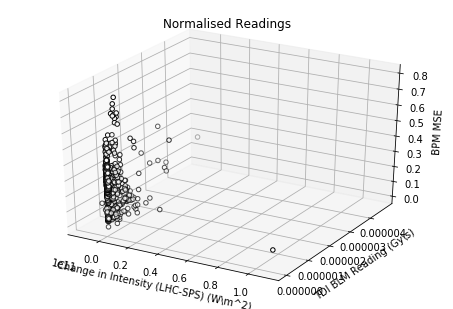

In [4]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Data['normLHC-SPS'],Data['normBLM'],Data['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Normalised Readings')
plt.show()

### Remove Outliers

In [5]:
Data = Data.replace([np.inf, -np.inf], np.nan).dropna()

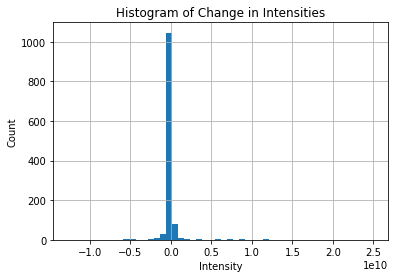

In [6]:
#cond = Data['normLHC-SPS']>-2e13
cond = Data['normLHC-SPS']<0.8e11
data =Data[cond]
plt.figure()
data['normLHC-SPS'].hist(bins = 50)
plt.title('Histogram of Change in Intensities')
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.savefig('../Dissertation/images/Histogram_of_Change_in_Intensities_B2')

In [7]:
len(Data['normLHC-SPS'])

1212

### Scaling the Data

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
features = ['normAbort Gap Reading','normLHC-SPS','normBLM','BPM MSE','BPM Reading 1','BPM Reading 2','BPM Reading 3','BPM Reading 4',
           'BPM Reading 5','BPM Reading 6','BPM Reading 7','BPM Reading 8','BPM Reading 9','BPM Reading 10',
           'BPM Reading 11','BPM Reading 12','BPM Reading 13','BPM Reading 14','BPM Reading 15','BPM Reading 16',
           'BPM Reading 17','BPM Reading 18','Change in Number of Bunches']
#Separate out the features
x = data.loc[:,features].values
x = StandardScaler().fit_transform(x)

In [10]:
x = pd.DataFrame(columns=features,data=x)

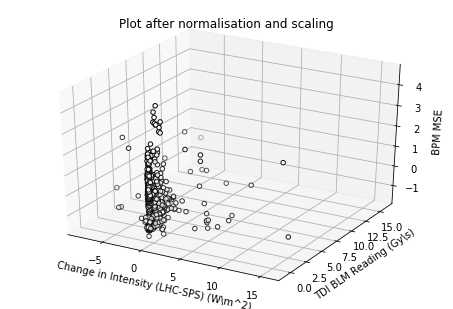

In [11]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x['normLHC-SPS'],x['normBLM'],x['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Plot after normalisation and scaling')
plt.show()

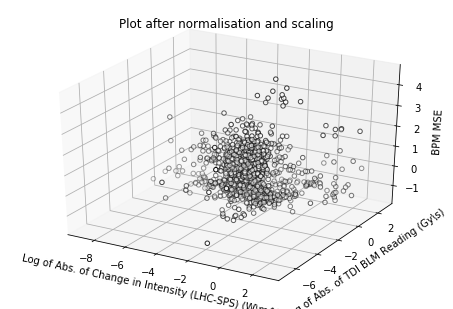

In [12]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.log(np.abs(x['normLHC-SPS'])),np.log(np.abs(x['normBLM'])),x['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Log of Abs. of Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('Log of Abs. of TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Plot after normalisation and scaling')
plt.show()

### 3D LoF

In [13]:
from sklearn.neighbors import LocalOutlierFactor

In [14]:
df = pd.DataFrame(data ={'Change in Intensities':x['normLHC-SPS'],
                         'BLM':x['normBLM'],'BPM MSE':x['BPM MSE']} )

df.head()

,Change in Intensities,BLM,BPM MSE
0,-0.103053,-0.515569,-1.493332
1,0.965416,0.428207,-1.479977
2,0.212335,1.044315,-1.413300
3,0.507552,0.936785,-1.278358
4,-0.136732,-0.557343,-1.171578


In [15]:
lof = LocalOutlierFactor(n_neighbors=50, n_jobs=-1).fit_predict(df)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [16]:
df['Predicted Value'] = lof
is_anomaly = df['Predicted Value']==-1
Anomalies = df[is_anomaly]

not_anomaly = df['Predicted Value']!=-1
Inliers = df[not_anomaly]

In [17]:
len(Anomalies['Predicted Value'])

122

In [15]:
data[data.index.isin(df[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_3D_LoF.pkl')

In [35]:
df.to_pickle(path='../Data/Beam2_data.pkl')

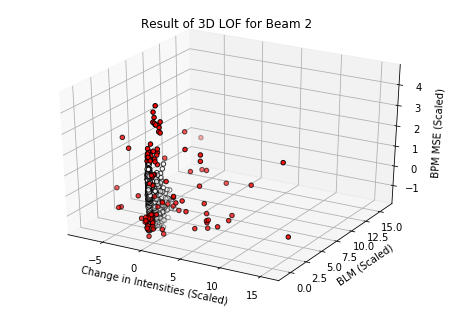

In [36]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['Change in Intensities'],Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['Change in Intensities'],Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities (Scaled)')
ax.set_ylabel('BLM (Scaled)')
ax.set_zlabel('BPM MSE (Scaled)')
ax.set_title('Result of 3D LOF for Beam 2')
plt.savefig('../Dissertation/images/Beam2_3D_LOF_Results', bbox_inches='tight')
plt.show()

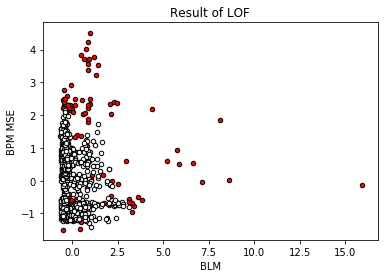

In [17]:
plt.figure()
plt.scatter(Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
plt.xlabel('BLM')
plt.ylabel('BPM MSE')
plt.title('Result of LOF')
plt.show()

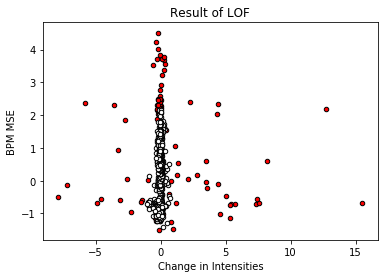

In [18]:
plt.figure()
plt.scatter(Anomalies['Change in Intensities'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['Change in Intensities'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
plt.xlabel('Change in Intensities')
plt.ylabel('BPM MSE')
plt.title('Result of LOF')
plt.show()

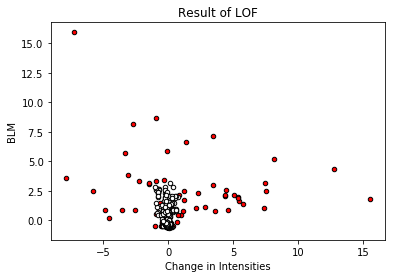

In [19]:
plt.figure()
plt.scatter(Anomalies['Change in Intensities'],Anomalies['BLM'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['Change in Intensities'],Inliers['BLM'],c='white',
                edgecolor='k', s=20)
plt.xlabel('Change in Intensities')
plt.ylabel('BLM')
#plt.yscale('log')
#plt.ylim(0,0.004)
plt.title('Result of LOF')
plt.show()

### 3D DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

In [21]:
clustering = DBSCAN(min_samples=10,n_jobs=-1).fit(df.drop('Predicted Value',axis=1))

In [22]:
df['Predicted Value'] = clustering.labels_
is_anomaly = df['Predicted Value']==-1
Anomalies = df[is_anomaly]

not_anomaly = df['Predicted Value']!=-1
Inliers = df[not_anomaly]

In [23]:
len(Anomalies['Predicted Value'])

86

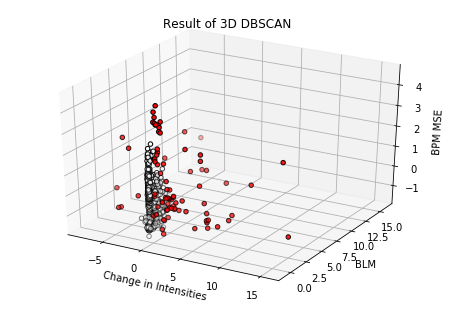

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['Change in Intensities'],Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['Change in Intensities'],Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of 3D DBSCAN')
plt.savefig('../Dissertation/images/Beam2_3D_DBSCAN_Results')
plt.show()

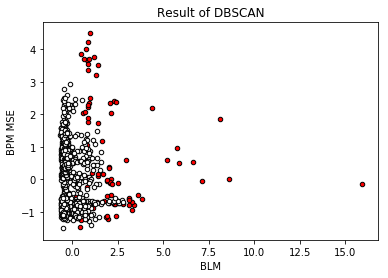

In [25]:
plt.figure()
plt.scatter(Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
plt.xlabel('BLM')
plt.ylabel('BPM MSE')
plt.title('Result of DBSCAN')
plt.savefig('../Dissertation/images/Beam2_3D_DBSCAN_BLMBPM')
plt.show()

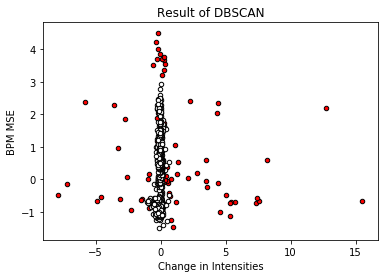

In [26]:
plt.figure()
plt.scatter(Anomalies['Change in Intensities'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['Change in Intensities'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
plt.xlabel('Change in Intensities')
plt.ylabel('BPM MSE')
plt.title('Result of DBSCAN')
plt.savefig('../Dissertation/images/Beam2_3D_DBSCAN_ResultsBPMIntensity')
plt.show()

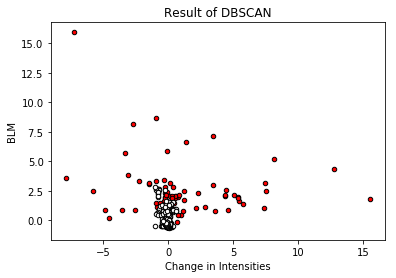

In [27]:
plt.figure()
plt.scatter(Anomalies['Change in Intensities'],Anomalies['BLM'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['Change in Intensities'],Inliers['BLM'],c='white',
                edgecolor='k', s=20)
plt.xlabel('Change in Intensities')
plt.ylabel('BLM')
#plt.yscale('log')
#plt.ylim(0,0.004)
plt.title('Result of DBSCAN')
plt.show()

In [28]:
data[data.index.isin(df[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_3D_DBSCAN.pkl')

### LoF with all parameters

In [29]:
bpm_mse = x['BPM MSE']
x = x.drop('BPM MSE', axis=1)
x.head()

,normAbort Gap Reading,normLHC-SPS,normBLM,BPM Reading 1,BPM Reading 2,BPM Reading 3,BPM Reading 4,BPM Reading 5,BPM Reading 6,BPM Reading 7,...,BPM Reading 10,BPM Reading 11,BPM Reading 12,BPM Reading 13,BPM Reading 14,BPM Reading 15,BPM Reading 16,BPM Reading 17,BPM Reading 18,Change in Number of Bunches
0,0.138818,-0.103053,-0.515569,1.090343,-0.716026,1.169794,-2.206251,1.752988,-1.361712,2.090725,...,0.807766,-1.992573,1.176046,-0.848290,-1.307491,1.106846,-1.298426,1.106846,-1.298426,-0.513806
1,2.698921,0.965416,0.428207,1.013898,-0.706736,1.065191,-0.232797,1.669995,-0.144705,2.359479,...,0.442144,-2.449711,1.416837,-1.110157,0.515144,1.093402,-0.526071,1.093402,-0.526071,-2.455278
2,0.938938,0.212335,1.044315,1.185135,-0.774864,1.175090,0.149934,1.852580,-0.105319,2.434322,...,0.375310,-2.062902,1.269079,-0.416641,-0.104552,1.382436,-0.500326,1.382436,-0.500326,-2.455278
3,0.251304,0.507552,0.936785,1.139268,-1.431377,0.992366,0.245616,1.375368,0.603617,1.917225,...,-0.312689,-1.858948,0.470093,-0.802247,0.393635,1.103485,0.375009,1.103485,0.375009,-2.455278
4,-0.067075,-0.136732,-0.557343,1.148441,-1.908278,1.173766,-2.050767,1.640947,0.103423,1.934235,...,-0.595752,-1.408843,0.207413,-0.287146,-0.177457,0.874947,0.211956,0.874947,0.211956,0.595607


In [30]:
lof = LocalOutlierFactor(n_neighbors=50, n_jobs=-1).fit_predict(x)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [31]:
x['BPM MSE'] = bpm_mse

In [ ]:
x.to_pickle(path='../Data/Beam2_FullData.pkl')

In [32]:
x['Predicted Value'] = lof
is_anomaly = x['Predicted Value']==-1
Anomalies = x[is_anomaly]

not_anomaly = x['Predicted Value']!=-1
Inliers = x[not_anomaly]

In [33]:
len(Anomalies['normBLM'])

122

In [34]:
data[data.index.isin(x[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_Full_LoF.pkl')

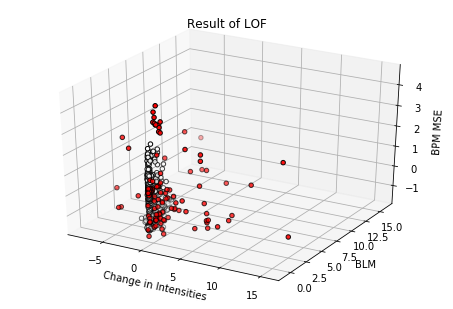

In [35]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of LOF')
plt.show()

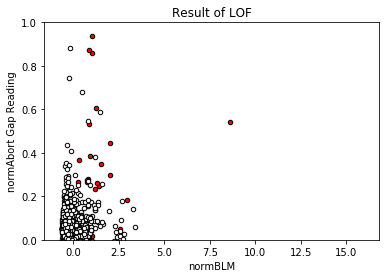

In [36]:
plt.figure()
plt.scatter(Anomalies['normBLM'],Anomalies['normAbort Gap Reading'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['normBLM'],Inliers['normAbort Gap Reading'],c='white',
                edgecolor='k', s=20)
plt.xlabel('normBLM')
plt.ylabel('normAbort Gap Reading')
#plt.yscale('log')
plt.ylim(0,1)
plt.title('Result of LOF')
plt.show()

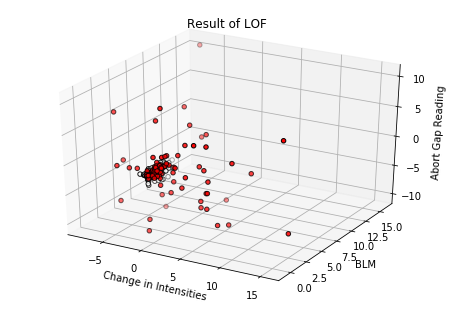

In [37]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['normAbort Gap Reading'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['normAbort Gap Reading'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('Abort Gap Reading')
ax.set_title('Result of LOF')
plt.show()

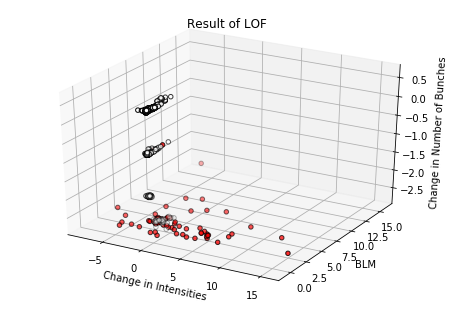

In [38]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['Change in Number of Bunches'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['Change in Number of Bunches'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('Change in Number of Bunches')
ax.set_title('Result of LOF')
plt.show()

### Full Model DBSCAN

In [39]:
x = x.drop('BPM MSE', axis=1)
x = x.drop('Predicted Value', axis=1)
x.head()

,normAbort Gap Reading,normLHC-SPS,normBLM,BPM Reading 1,BPM Reading 2,BPM Reading 3,BPM Reading 4,BPM Reading 5,BPM Reading 6,BPM Reading 7,...,BPM Reading 10,BPM Reading 11,BPM Reading 12,BPM Reading 13,BPM Reading 14,BPM Reading 15,BPM Reading 16,BPM Reading 17,BPM Reading 18,Change in Number of Bunches
0,0.138818,-0.103053,-0.515569,1.090343,-0.716026,1.169794,-2.206251,1.752988,-1.361712,2.090725,...,0.807766,-1.992573,1.176046,-0.848290,-1.307491,1.106846,-1.298426,1.106846,-1.298426,-0.513806
1,2.698921,0.965416,0.428207,1.013898,-0.706736,1.065191,-0.232797,1.669995,-0.144705,2.359479,...,0.442144,-2.449711,1.416837,-1.110157,0.515144,1.093402,-0.526071,1.093402,-0.526071,-2.455278
2,0.938938,0.212335,1.044315,1.185135,-0.774864,1.175090,0.149934,1.852580,-0.105319,2.434322,...,0.375310,-2.062902,1.269079,-0.416641,-0.104552,1.382436,-0.500326,1.382436,-0.500326,-2.455278
3,0.251304,0.507552,0.936785,1.139268,-1.431377,0.992366,0.245616,1.375368,0.603617,1.917225,...,-0.312689,-1.858948,0.470093,-0.802247,0.393635,1.103485,0.375009,1.103485,0.375009,-2.455278
4,-0.067075,-0.136732,-0.557343,1.148441,-1.908278,1.173766,-2.050767,1.640947,0.103423,1.934235,...,-0.595752,-1.408843,0.207413,-0.287146,-0.177457,0.874947,0.211956,0.874947,0.211956,0.595607


In [47]:
clustering = DBSCAN(n_jobs=-1).fit(x)

In [48]:
x['BPM MSE'] = bpm_mse

In [49]:
x['Predicted Value'] = clustering.labels_
is_anomaly = x['Predicted Value']==-1
Anomalies = x[is_anomaly]

not_anomaly = x['Predicted Value']!=-1
Inliers = x[not_anomaly]

In [50]:
len(Anomalies['normBLM'])

596

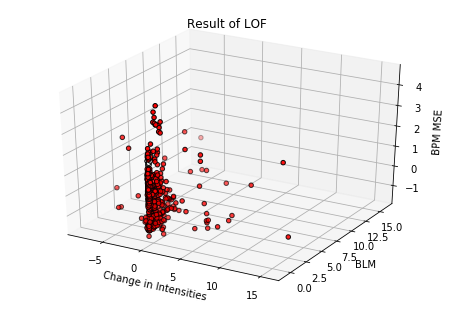

In [51]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of LOF')
plt.show()

Curse of Dimensionality Clearly has effect here!

### PCA:

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(n_components=0.8)

In [54]:
x = x.drop('Predicted Value',axis=1)
x = x.drop('BPM MSE',axis=1)

In [55]:
principalComponents = pca.fit_transform(x)
df = pd.DataFrame(data = principalComponents)
df.head()

,0,1,2,3,4
0,-3.955587,3.143179,1.606101,-0.608462,1.811799
1,-1.591454,3.609389,2.598911,2.072011,1.914274
2,-1.700447,4.060274,2.848567,1.860530,1.150927
3,0.212976,4.296999,1.946089,1.685810,1.536376
4,-1.041077,4.477261,-0.203497,-0.668248,0.925027


In [56]:
lof = LocalOutlierFactor(n_neighbors=20, n_jobs=-1).fit_predict(df)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [59]:
x['BPM MSE'] = bpm_mse

In [60]:
x['Predicted Value'] = lof
is_anomaly = x['Predicted Value']==-1
Anomalies = x[is_anomaly]

not_anomaly = x['Predicted Value']!=-1
Inliers = x[not_anomaly]

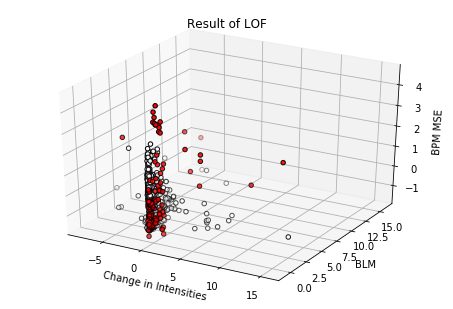

In [61]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of LOF')
plt.show()

In [62]:
df['Predicted Value'] = lof
is_anomaly = df['Predicted Value']==-1
Anomalies = df[is_anomaly]

not_anomaly = df['Predicted Value']!=-1
Inliers = df[not_anomaly]

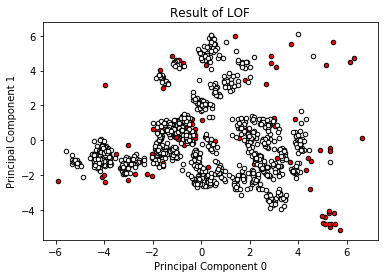

In [63]:
plt.figure()
plt.scatter(Anomalies[0],Anomalies[1],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers[0],Inliers[1],c='white',
                edgecolor='k', s=20)
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
#plt.ylim(0,0.004)
plt.title('Result of LOF')
plt.show()

In [64]:
len(Anomalies[0])

122

In [82]:
data[data.index.isin(df[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_PCA_LoF.pkl')

In [74]:
clustering = DBSCAN(delta=0.3,min_samples=5,n_jobs=-1).fit(df.drop('Predicted Value', axis=1))

TypeError: __init__() got an unexpected keyword argument 'delta'

In [71]:
x['Predicted Value'] = clustering.labels_
is_anomaly = x['Predicted Value']==-1
Anomalies = x[is_anomaly]

not_anomaly = x['Predicted Value']!=-1
Inliers = x[not_anomaly]

In [72]:
len(Anomalies['Predicted Value'])

235

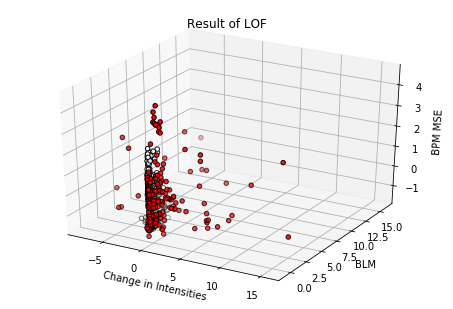

In [73]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of LOF')
plt.show()